# MODULE 3 : SEQUENTIAL PATTERN MINING

---

### libraries

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import numpy as np
from scipy.stats import norm

from sktime.transformations.series.sax import SAX
from pymining import seqmining
from gsp_python.gsp import GSP

---

### 2) sequential pattern mining

[sax docs](https://www.sktime.net/en/v0.31.0/api_reference/auto_generated/sktime.transformations.series.sax.SAX.html)

[gsp docs](https://pypi.org/project/gsp-python/)

In [14]:
"""
Sequential Pattern Mining on Movie Time Series using gsp_python (GSP algorithm)
1. Load CSV, drop meta‐columns
2. Extract 100‐day series
3. Discretize each series via sktime’s SAX
4. Build dataset for gsp_python
5. Run GSP
6. Print top‐K patterns with support and level labels
"""

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
WORD_SIZE     = 7      # SAX word length
ALPHABET_SIZE = 5       # SAX alphabet size
MIN_SUPPORT   = 0.2     # relative (<1) or absolute (>=1)
TOP_K         = 100      # how many top patterns to display
# ───────────────────────────────────────────────────────────────────────────────

# 1) Load & drop meta‐columns
df = pd.read_csv("../../../0) dataset/3) time series preprocessed/preprocessed.csv")
df = df.drop(columns=['id','rating','genre','rating_category','rating_category_ord'], errors='ignore')

# 2) Extract the 100‐day series
ts = df.iloc[:, :100].astype(float).values
n_series = ts.shape[0]

# 3) SAX discretization (z‐norm + PAA + quantile‐binning)
sax = SAX(word_size=WORD_SIZE, alphabet_size=ALPHABET_SIZE, frame_size=0)
alphabet = [chr(ord('a') + i) for i in range(ALPHABET_SIZE)]
sym2id   = {sym: i+1 for i, sym in enumerate(alphabet)}  # event IDs 1…5

# Define qualitative labels for each symbol
label_map = {'a': 'low', 'b': 'medium low', 'c': 'medium', 'd': 'medium high', 'e': 'high'}

# 4) Build dataset for GSP: each series → [[eid1], [eid2], ...]
dataset = []
for series in ts:
    codes = sax.fit_transform(series).astype(int)  # ints 0…4
    seq = [[ sym2id[alphabet[c]] ] for c in codes]
    dataset.append(seq)

# 5) Run GSP
minsup_param = MIN_SUPPORT if 0<MIN_SUPPORT<1 else int(MIN_SUPPORT)
algo = GSP(dataset, minsup=minsup_param)
results = algo.run_gsp()  # list of (pattern, support)

# 6) Sort and display top‐K patterns
sorted_results = sorted(results, key=lambda x: (x[1], len(x[0])), reverse=True)
print(f"\nFound {len(results)} patterns (minsup = {minsup_param})")
print(f"Top {min(TOP_K, len(sorted_results))} patterns:\n")


# reverse map for display
id2sym = {v: k for k, v in sym2id.items()}
for i, (pattern, sup) in enumerate(sorted_results[:TOP_K], 1):
    syms = [ id2sym[e[0]] for e in pattern ]
    pat_str = "".join(syms)
    levels = [label_map[s] for s in syms]
    levels_str = " → ".join(levels)
    print(f"{i:2d}. Pattern: {pat_str:<{WORD_SIZE}}  Support: {sup}")
    print(f"    Levels: {levels_str}\n")




Found 95 patterns (minsup = 0.2)
Top 95 patterns:

 1. Pattern: a        Support: 1090
    Levels: low

 2. Pattern: e        Support: 1073
    Levels: high

 3. Pattern: c        Support: 1050
    Levels: medium

 4. Pattern: d        Support: 1027
    Levels: medium high

 5. Pattern: b        Support: 998
    Levels: medium low

 6. Pattern: ec       Support: 969
    Levels: high → medium

 7. Pattern: ea       Support: 968
    Levels: high → low

 8. Pattern: ed       Support: 964
    Levels: high → medium high

 9. Pattern: eb       Support: 927
    Levels: high → medium low

10. Pattern: ca       Support: 922
    Levels: medium → low

11. Pattern: dc       Support: 916
    Levels: medium high → medium

12. Pattern: da       Support: 899
    Levels: medium high → low

13. Pattern: eca      Support: 898
    Levels: high → medium → low

14. Pattern: cb       Support: 883
    Levels: medium → medium low

15. Pattern: eda      Support: 882
    Levels: high → medium high → low

16. Pa

In [6]:
# PARAMETERS
DATA_PATH     = "../../../0) dataset/3) time series preprocessed/preprocessed.csv"
WORD_SIZE     = 5
ALPHABET_SIZE = 5
MIN_SUPPORT   = 0.1
TOP_K         = 10

# 1) Load data (retain metadata)
df = pd.read_csv(DATA_PATH)
df = df.drop(columns=['id'], errors='ignore')

# 2) Prepare SAX discretizer and alphabet
sax = SAX(word_size=WORD_SIZE, alphabet_size=ALPHABET_SIZE, frame_size=0)
alphabet = [chr(ord('a') + i) for i in range(ALPHABET_SIZE)]
sym2id = {sym: i+1 for i, sym in enumerate(alphabet)}
id2sym = {v: k for k, v in sym2id.items()}
label_map = {'a': 'low', 'b': 'medium low', 'c': 'medium', 'd': 'medium high', 'e': 'high'}

# Utility to mine a subset
def mine_group(subset_df):
    ts = subset_df.iloc[:, :100].astype(float).values
    dataset = []
    for series in ts:
        codes = sax.fit_transform(series).astype(int)
        seq = [[sym2id[alphabet[c]]] for c in codes]
        dataset.append(seq)
    n = len(dataset)
    minsup = MIN_SUPPORT if 0 < MIN_SUPPORT < 1 else int(MIN_SUPPORT)
    if 0 < MIN_SUPPORT < 1:
        minsup = max(1, int(MIN_SUPPORT * n))
    algo = GSP(dataset, minsup=minsup)
    results = algo.run_gsp()
    sorted_results = sorted(results, key=lambda x: (x[1], len(x[0])), reverse=True)
    return sorted_results[:TOP_K]

# 3) Compare by rating_category
for category, group_df in df.groupby('rating_category'):
    print(f"\n=== Rating Category: {category} ({len(group_df)} movies) ===")
    top_patterns = mine_group(group_df)
    for i, (pattern, sup) in enumerate(top_patterns, 1):
        syms = [id2sym[e[0]] for e in pattern]
        levels = " → ".join(label_map[s] for s in syms)
        pat_str = "".join(syms)
        print(f"{i:2d}. {pat_str:<{WORD_SIZE}}  Support: {sup}  Levels: {levels}")

# 4) (Optional) Compare by primary genre
# Assuming genre column is a string list like "['Action', 'Sci-Fi']"
def primary_genre(genres):
    return genres.strip("[]' ").split("', '")[0]

df['primary_genre'] = df['genre'].apply(primary_genre)
for genre, group_df in df.groupby('primary_genre'):
    print(f"\n=== Primary Genre: {genre} ({len(group_df)} movies) ===")
    top_patterns = mine_group(group_df)
    for i, (pattern, sup) in enumerate(top_patterns, 1):
        syms = [id2sym[e[0]] for e in pattern]
        levels = " → ".join(label_map[s] for s in syms)
        pat_str = "".join(syms)
        print(f"{i:2d}. {pat_str:<{WORD_SIZE}}  Support: {sup}  Levels: {levels}")


=== Rating Category: High (370 movies) ===

=== Rating Category: Low (10 movies) ===
 1. ea     Support: 10  Levels: high → low
 2. e      Support: 10  Levels: high
 3. a      Support: 10  Levels: low

=== Rating Category: Medium (381 movies) ===

=== Rating Category: Medium High (232 movies) ===

=== Rating Category: Medium Low (126 movies) ===

=== Primary Genre: Action (318 movies) ===

=== Primary Genre: Adventure (73 movies) ===

=== Primary Genre: Animation (119 movies) ===

=== Primary Genre: Biography (122 movies) ===

=== Primary Genre: Comedy (201 movies) ===

=== Primary Genre: Crime (39 movies) ===

=== Primary Genre: Documentary (26 movies) ===

=== Primary Genre: Drama (150 movies) ===

=== Primary Genre: Fantasy (2 movies) ===
 1. edcba  Support: 2  Levels: high → medium high → medium → medium low → low
 2. edcb   Support: 2  Levels: high → medium high → medium → medium low
 3. edca   Support: 2  Levels: high → medium high → medium → low
 4. edba   Support: 2  Levels: h

DEBUG:__init__:matplotlib data path: /opt/anaconda3/lib/python3.12/site-packages/matplotlib/mpl-data
DEBUG:__init__:CONFIGDIR=/Users/riccardo/.matplotlib
DEBUG:__init__:interactive is False
DEBUG:__init__:platform is darwin
DEBUG:__init__:CACHEDIR=/Users/riccardo/.matplotlib
DEBUG:font_manager:Using fontManager instance from /Users/riccardo/.matplotlib/fontlist-v390.json
DEBUG:pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:font_manager:findfont: score(FontEntry(fname='/opt/anaconda3/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:font_manager:findfont: score(FontEntry(fname='/opt/anaconda3/lib/pyt

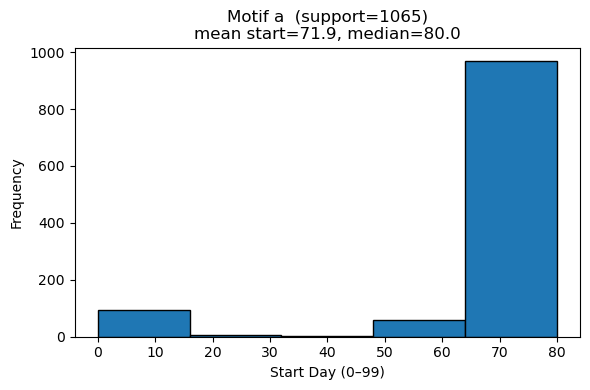

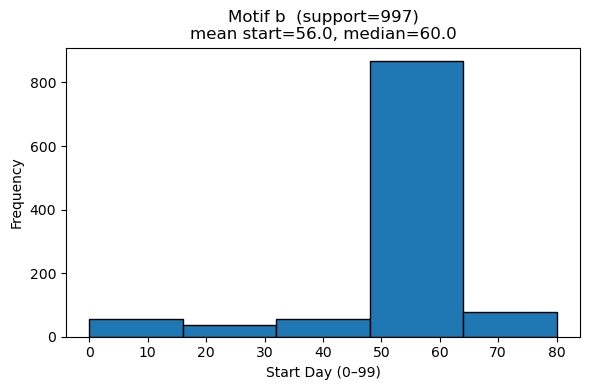

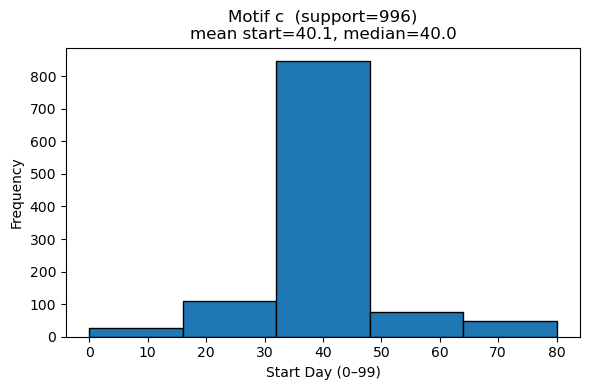

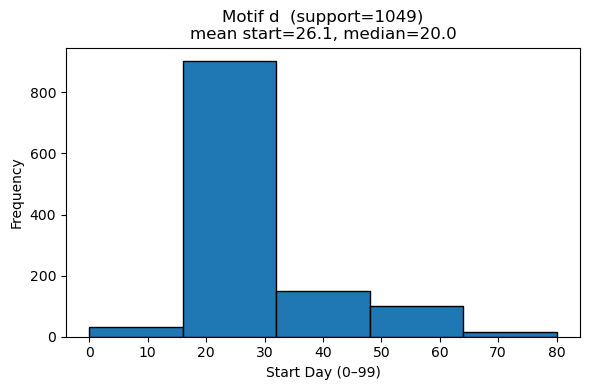

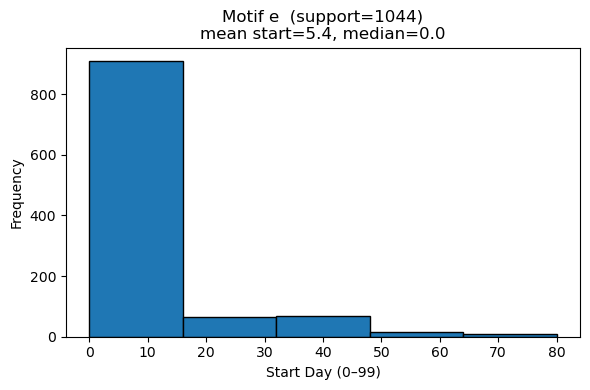

In [7]:
#!/usr/bin/env python3
"""
Mine & Localize Motifs in 100-day Movie Series

1. Load & drop metadata
2. Discretize via SAX (z-norm + PAA + quantile bins)
3. Mine top-K patterns with GSP (using RELATIVE support)
4. Localize those motifs in the same sequences
5. Plot start-day histograms
"""

import matplotlib.pyplot as plt

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
DATA_PATH     = "../../../0) dataset/3) time series preprocessed/preprocessed.csv"
WORD_SIZE     = 5      # number of PAA frames
ALPHABET_SIZE = 5      # number of quantile bins / symbols
MIN_SUPPORT   = 0.2    # ALWAYS RELATIVE for gsp_python
TOP_K         = 30     # how many patterns to mine
NUM_PLOTS     = 5      # how many of those to localize & plot
# ───────────────────────────────────────────────────────────────────────────────

label_map = {'a': 'low', 'b': 'medium low', 'c': 'medium', 'd': 'medium high', 'e': 'high'}

def discretize_series(series, word_size, alphabet_size):
    # 1) Z-normalize
    s = (series - series.mean()) / series.std()
    # 2) PAA into `word_size` frames
    frames = np.array_split(s, word_size)
    paa = np.array([f.mean() for f in frames])
    # 3) quantile breakpoints from standard normal
    bps = norm.ppf(np.linspace(1/alphabet_size,
                               1-1/alphabet_size,
                               alphabet_size-1))
    # codes ∈ {0,...,alphabet_size-1}
    return np.digitize(paa, bps)

def find_positions(seq, motif):
    L = len(motif)
    return [i for i in range(len(seq)-L+1) if seq[i:i+L] == motif]


# 1) Load + drop meta
df = pd.read_csv(DATA_PATH)
df = df.drop(columns=['id','rating','genre','rating_category','rating_category_ord'], errors='ignore')

# 2) Extract & discretize all series
ts = df.iloc[:, :100].astype(float).values
n = ts.shape[0]

alphabet = [chr(ord('a')+i) for i in range(ALPHABET_SIZE)]
sym2id   = {s:i+1 for i,s in enumerate(alphabet)}
id2sym   = {i+1:s for i,s in enumerate(alphabet)}

sequences = []  # for localization
dataset   = []  # for GSP

for series in ts:
    codes = discretize_series(series, WORD_SIZE, ALPHABET_SIZE)
    syms  = [alphabet[c] for c in codes]
    sequences.append(syms)
    dataset.append([[ sym2id[s] ] for s in syms])

# 3) Mine with GSP using RELATIVE support
algo    = GSP(dataset, minsup=MIN_SUPPORT)
results = algo.run_gsp()

# 4) Pick top-K patterns
top_patterns = sorted(results, key=lambda x:(x[1], len(x[0])), reverse=True)[:TOP_K]

"""print(f"Mined {len(results)} patterns (minsup = {MIN_SUPPORT}) — showing top {TOP_K}\n")
for i,(pat,sup) in enumerate(top_patterns,1):
    syms = [id2sym[e[0]] for e in pat]
    print(f"{i:2d}. {''.join(syms):<{WORD_SIZE}}  support={sup}")
print(f"\nNow localizing and plotting the first {NUM_PLOTS} motifs...\n")"""

# 5) Localize & collect occurrences
FRAME_DAYS = 100 / WORD_SIZE
occ = []
for pat,sup in top_patterns[:NUM_PLOTS]:
    motif = [id2sym[e[0]] for e in pat]
    for seq in sequences:
        for pos in find_positions(seq, motif):
            day = int(pos * FRAME_DAYS)
            occ.append(( "".join(motif), sup, day ))

occ_df = pd.DataFrame(occ, columns=['motif','support','start_day'])

# 6) Plot histograms with stats
for motif, grp in occ_df.groupby('motif'):
    plt.figure(figsize=(6,4))
    plt.hist(grp['start_day'], bins=WORD_SIZE, edgecolor='black')
    plt.title(
        f"Motif {motif}  (support={grp['support'].iloc[0]:.0f})\n"
        f"mean start={grp['start_day'].mean():.1f}, "
        f"median={grp['start_day'].median():.1f}"
    )
    plt.xlabel("Start Day (0–99)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()